## Problem set Demand Estimation

Agustina Colonna 

PhD Economics UZH 2021

In [1]:
import os
import pandas as pd
import scipy.sparse as sci
import statsmodels.formula.api as smf
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import block_diag
from numpy.linalg import inv
from linearmodels.iv import IVGMM
from linearmodels.iv import IV2SLS
import numpy.linalg as lin
import matplotlib.pyplot as plt

# https://notes.quantecon.org/submission/5b3b1856b9eab00015b89f90

In [2]:
os.chdir('/Users/agcolo/Dropbox/PhDCourses_Zurich/Second_year/Empirical_IO/Problem Set Demand')

colnames = ['market_id', 'product_id', 'product_ms', 'productatt_1',  'productatt_2',  'productatt_3', 'price', 'costshift_1', 'costshift_2', 'costshift_3', 'group']

df = pd.read_csv('Data.csv', names = colnames , header=None)

In [3]:
# Create market shares relative to outside good 

df['totalms'] = df.groupby('market_id').transform('sum')['product_ms']

df['product0_ms'] = 1 - df.totalms 

df = df.assign(log_ms_rel = np.log(df['product_ms'] / df['product0_ms']))

## Logit Demand

In [10]:
## OLS ###
Logit_OLS = smf.ols(' log_ms_rel ~ price + productatt_1 + productatt_2 + productatt_3', data=df)
Logit_OLS.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_ms_rel   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 22 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:27:15   Log-Likelihood:                -1491.9
No. Observations:                 970   AIC:                             2994.
Df Residuals:                     965   BIC:                             3018.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9496      0.163      5.818      0.000       0.629       1.270
price           -1.3385      0.028    -47.054      0.000      -1.394      -1.283
productatt_1     2.4160      0.045     53.906      0.000       2.328       2.504
productatt_2     0.5124      0.045     11.319      0.000       0.424       0.601
productatt_3     0.3696      0.043      8.689      0.000       0.286       0.453
==============================================================================
Omnibus:                        2.031   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.362   Jarque-Bera (JB):                2.082
Skew:                           0.088   Prob(JB):                        0.353
Kurtosis:                       2.857   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
### IV ###
Logit_IV = IV2SLS.from_formula('log_ms_rel ~ 1 + [price ~ costshift_1 + costshift_2 + costshift_3] + productatt_1 + productatt_2 + productatt_3', data=df)
res_Logit_IV = Logit_IV.fit()
res_Logit_IV.summary #less steep slope. makes sense

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:             log_ms_rel   R-squared:                      0.8400
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8393
No. Observations:                 970   F-statistic:                    3905.7
Date:                Mon, Nov 22 2021   P-value (F-stat)                0.0000
Time:                        20:27:18   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept        1.6129     0.2304     7.0003     0.0000      1.1613      2.0644
productatt_1     2.4668     0.0478     51.598     0.0000      2.3731      2.5605
productatt_2     0.5616     0.0491     11.435     0.0000      0.4653      0.6579
productatt_3     0.3725     0.0444     8.3935     0.0000      0.2855      0.4595
price           -1.4571     0.0417    -34.962     0.0000     -1.5388     -1.3754
================================================================================

Endogenous: price
Instruments: costshift_1, costshift_2, costshift_3
Robust Covariance (Heteroskedastic)
Debiased: False
"""

We see that when computing the demand with IV, the coefficient on price is more elastic (greater in absolute value). This is as expected, because endogenetiy bias in demand estimation results in too inelastic demand curves

## Logit elasticities

Own price elasticity :

$$

e_{jj} = \alpha * p_{jn} * (1- s_{jn})

$$

Cross price elasticities

$$

e_{jk} = -  \alpha * p_{kn} * s_{kn}

$$



In [17]:
## Elasticities ##
results = pd.read_html(res_Logit_IV.summary.tables[1].as_html(),header=0,index_col=0)[0]
alpha = results['Parameter'].values[4]

# own price elasticities

df['e_jj'] = alpha * df.price * (1-df.product_ms)

df.groupby('market_id').e_jj.mean() # Mean own price elasticities for each market

np.mean(df.e_jj) # mean across all markets


-7.993711546538995

In [23]:
# cross product elasticities 

df['e_jk'] = -alpha * df.price * df.product_ms

# Now I calculate the mean across markets. Note that the weights for each cross product elasticity is the size of the market - 1 (because I don't count that same product)

sum((df.groupby('market_id').transform('count')['e_jj'] - 1)  * df['e_jk']) / sum((df.groupby('market_id').transform('count')['e_jj'] - 1))

0.13067276570741612

## GMM estimation Logit

In [35]:
## GMM estimation ##

## Function defining GMM moments ##

def moments(params, args):

    alpha, beta1, beta2, beta3, gamma1, gamma2, gamma3 , delta1, delta2, delta3, k1, k2 = params

    beta = np.array([beta1,beta2,beta3])
    gamma = np.array([gamma1,gamma2,gamma3])
    delta = np.array([delta1,delta2,delta3])

    productcat, price, MS, MS_r, costshift , W_hat = args

    n_obs = costshift[0].shape[0]

    psi = np.array(MS_r - k1 * np.ones(n_obs) - alpha * price - beta.dot(productcat)) # Demand side

    omega = np.array(price - k2 * np.ones(n_obs) - gamma.dot(costshift) -  delta.dot(productcat) - 1/(alpha*(MS-1))) # Supply side

    instruments = np.concatenate((np.ones(970).reshape(1, 970), productcat, costshift), axis = 0)

    instruments_sparse =  block_diag(instruments, instruments) # Multiple GMM estimation, matrix with many zeros

    errors = np.array([psi, omega]).reshape(costshift.shape[1]*2,1)

    moments = instruments_sparse.dot(errors) # Z'e

    return moments 

In [36]:
# Function defining distance estimator = (Z'e)' W (Z'e)

def criterion(params, *args ):

    alpha, beta1, beta2, beta3, gamma1, gamma2, gamma3 , delta1, delta2, delta3 , k1, k2 = params

    productcat, price, MS, MS_r, costshift, W_hat = args

    mom = moments(params, args)
    
    crit_val = np.dot(np.dot(mom.T, W_hat), mom) 
    
    return crit_val.item()

In [37]:
# Define inputs for function #

alpha = -1.35
beta1 = 2
beta2 = 1.5
beta3 = 1
gamma1 = 1
gamma2 = 2
gamma3 = 1
delta1 = 0.5
delta2 = 1
delta3 = 1 
k1 = 1
k2 = 1

productcat = np.array([df.productatt_1, df.productatt_2, df.productatt_3])
costshift = np.array([df.costshift_1, df.costshift_2, df.costshift_3])

price = df.price
MS = df.product_ms
MS_r = df.log_ms_rel

In [38]:
# Starting values 

my_start = np.array([alpha, beta1, beta2, beta3, gamma1, gamma2, gamma3 , delta1, delta2, delta3, k1, k2])

W_hat = np.identity(14) ## Identity weighting matrix for first iteration

otherargs = (productcat, price, MS, MS_r, costshift, W_hat)


In [39]:
# First minimization with W = Identity

res = minimize(criterion, 
        my_start, 
        args = (otherargs) , 
        method = 'BFGS',
        tol = 500) 


In [40]:
print(res.x)
print(res.fun)

# printing in order: alpha, beta1, beta2, beta3, gamma1, gamma2, gamma3 , delta1, delta2, delta3, k1, k2

[-1.45160605  2.45499648  0.54291759  0.38612982  0.46669028  0.49504124
  0.45636169  0.04727386  0.05279015  0.0149131   1.58259735  4.91409038]
403.4760162079264


In [41]:
# Second step with W = Optimal weighting matrix

my_end = res.x

ZE = moments(res.x, otherargs)

W_hat = lin.pinv(ZE.dot(ZE.T)) # optimal weighting matrix

otherargs = (productcat, price, MS, MS_r, costshift, W_hat)

In [42]:
res2 = minimize(criterion, 
        my_end, 
        args = (otherargs) , 
        method = 'BFGS',
        tol = 1) 

In [43]:
print(res2.x)
print(res2.fun) # much smaller value! great!

# printing in order: alpha, beta1, beta2, beta3, gamma1, gamma2, gamma3 , delta1, delta2, delta3, k1, k2

# I could continue iterating over W to get smaller values of the objective function but parameters seem already quite stable

[-1.45160605  2.45499648  0.54291759  0.38612982  0.46669028  0.49504124
  0.45636169  0.04727386  0.05279015  0.0149131   1.58259735  4.91409038]
0.9999999999999996


In [44]:
# GMM results

{'alpha': res2.x[0],
'Beta1': res2.x[1],
'Beta2': res2.x[2],
'Beta3': res2.x[3],
'Gamma1':res2.x[4],
'Gamma2': res2.x[5],
'Gamma3': res2.x[6],
'Delta1': res2.x[7],
'Delta2': res2.x[8],
'Delta3': res2.x[9],
'K1': res2.x[10],
'K2': res2.x[11]}

{'alpha': -1.4516060502656292,
 'Beta1': 2.454996476088575,
 'Beta2': 0.5429175918961844,
 'Beta3': 0.386129815993271,
 'Gamma1': 0.46669028156590037,
 'Gamma2': 0.4950412449296972,
 'Gamma3': 0.4563616869681366,
 'Delta1': 0.04727385984170451,
 'Delta2': 0.05279015207997826,
 'Delta3': 0.01491310388559585,
 'K1': 1.5825973538908868,
 'K2': 4.914090376735372}

We see that the coefficient on price (alpha) and the coefficients on product categories are all very similar to the IV estimation without taking into account the supply side.

## Merger problem

Now for the merged firms (i,j) the price equation will be: 
$$
 p_{in} = mc_{in} - \frac{1}{\alpha(1-s_{in} - s_{jn})} = w_{in}'\gamma + x_{jn}'\delta - \frac{1}{\alpha(1-s_{in} - s_{jn})}  + \omega_{jn}
 $$
 While for the rest of the firms in the market it will be:
 $$
 p_{in} = mc_{in} - \frac{1}{\alpha(1-s_{in} )} = w_{in}'\gamma + x_{jn}'\delta - \frac{1}{\alpha(1-s_{in})}  + \omega_{jn}
 $$
 The demand equation is the same as before:
 $$ log(\frac{s_{jn}}{s_{0n}}) = \alpha p_{jn} + x_{jn} \beta + \xi_{jn}$$

 Now the idea is to iteratively solve those two equations using the estimate for $\alpha, \beta, \gamma$ estimated previously while setting the error terms $\epsilon_{n} \text{ and } \xi_{kn}$ to zero:
+ Start with curret prices and calculate $s_{jn}$.
+ Plug $s_{jn}$ into supply equation and get price vector $p_n$.
+ Repeat until previous and new values differ only by $10^{-3}$

In [34]:
# Identify two largest firms in each market

df_grouped = df.groupby('market_id')
df['highest_ms'] = df_grouped.transform(lambda x: x.nlargest(1).min())['product_ms']
df['second_highest_ms'] = df_grouped.transform(lambda x: x.nlargest(2).min())['product_ms']

# great dummies = 1 if the firm is one of the merged firms, also dummies for biggest and second biggest firm

df['merged_firm'] = np.where((df['product_ms']== df['highest_ms']) | (df['product_ms'] == df['second_highest_ms']), 1, 0)

df['highest_firm'] = np.where((df['product_ms']== df['highest_ms']), 1, 0)
df['second_highest_firm'] = np.where((df['product_ms'] == df['second_highest_ms']), 1, 0)

In [35]:
# Starting values are the results of the logit

alpha = res2.x[0]
beta1= res2.x[1]
beta2 = res2.x[2]
beta3 = res2.x[3]
gamma = res2.x[4:7]
delta = res2.x[7:10]
k1 = res2.x[10]
k2 = res2.x[11]
productcat = np.array([df.productatt_1, df.productatt_2, df.productatt_3])
costshift = np.array([df.costshift_1, df.costshift_2, df.costshift_3])
n_obs = costshift[0].shape[0]


In [48]:
## I compute initial market shares and mg costs

df['EXP'] = np.exp( k1  + alpha * df.price + beta1 * df['productatt_1'] + beta2 * df['productatt_2'] + beta3 *df['productatt_3']) # Exponential for probit
df['sumEXP'] = df.groupby('market_id').transform('sum')['EXP']
df['share_pre'] = df['EXP'] / (1 + df['sumEXP']) # market share using demand equation


MC = df['price'] + 1/(alpha*(1-df['share_pre'])) # MC using supply equation


In [37]:
price_iter = df.price
difference2 = 1
convergence = 1

In [38]:
# I keep the parameters fixed and solve for markets shares and prices to equate supply side and demand side
while convergence >= 1e-10 :

    differencepre = difference2

    price_d = price_iter

    # Demand side

    df['EXP'] = np.exp(k1 + alpha * price_d + beta1 * df['productatt_1'] + beta2 * df['productatt_2'] + beta3 *df['productatt_3'])
    df['sumEXP_'] = df.groupby('market_id').transform('sum')['EXP']
    df['MS_d'] = df['EXP'] / (1 + df['sumEXP_']) # market share using demand equation logit

    # Calculate new denominator for price equation

    ## first need to compute market shares of merged firms

    df['highest_ms2'] = np.where((df['highest_firm']== 1), df['MS_d'], 0) # MS of largest firm
    df['second_highest_ms2'] = np.where((df['second_highest_firm']== 1), df['MS_d'], 0) # MS of second largest firm

    df_grouped = df.groupby('market_id')

    df['highest_ms'] = df_grouped.transform('sum')['highest_ms2'] # one column for ms of largest firm in each market
    df['second_highest_ms'] = df_grouped.transform('sum')['second_highest_ms2']

    ## denominator of price equation --> 1-si for unmerged firms and 1-si-sj for merged firms

    DENOM = 1 - df['MS_d'] - df['highest_firm']*df['second_highest_ms'] - df['second_highest_firm']*df['highest_ms']

    # Supply side

    price_iter = MC - (alpha*(DENOM))**(-1)

    # Difference between demand and supply prices (euclidean distance)

    difference2 = (price_d - price_iter).T.dot((price_d - price_iter))

    # difference between the difference in the last step and the difference in this step

    convergence = abs(differencepre - difference2)



In [39]:
convergence

9.85682646614805e-11

In [40]:
# Now we compare pre and post merger

df['price_diff'] = (price_iter - df.price ) / df.price

df['MS_diff'] = (df.MS_d - df.share_pre) / df.share_pre

In [41]:
largest = df.loc[(df.highest_firm == 1)]
largest2 = df.loc[(df.second_highest_firm == 1)]

Plotting change in price and market share for merged firms

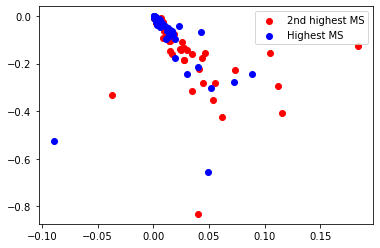

In [47]:
fig,ax = plt.subplots()

plt.scatter(largest2['price_diff'], largest2['MS_diff'], c='red', label='2nd highest MS')
plt.scatter(largest['price_diff'], largest['MS_diff'], c='blue', label='Highest MS')

plt.legend()

plt.show()

We see that for most of the merged firms, prices slightly increased and market shares slightly decreased. Note that most of the firms are very concentrated near zero indicating that prices and market shares barely changed. This may be because of the logit demand assumption, where all goods are equally substituable across eachother 

Plotting change in price and market share for unmerged firms:

No handles with labels found to put in legend.


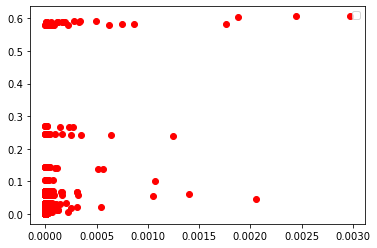

In [48]:
smaller = df.loc[(df.highest_firm != 1) & (df.second_highest_firm!=1)]

fig,ax = plt.subplots()

plt.scatter(smaller['price_diff'], smaller['MS_diff'], c='red')

plt.legend()

plt.show()

## Nested Logit

$$ log(\frac{s_{jn}}{s_{0n}}) = \alpha p_{jn} + x_{jn}\beta + \sigma log(\frac{s_{jn}}{s_{gn}}) + \xi_{jn} = \delta_{jn} + \sigma log(\frac{s_{jn}}{s_{gn}})$$ 

In [49]:
# calculate group share

df['groupshare'] = df.groupby(['group', 'market_id']).transform('sum')['product_ms']

df['relative_grp_ms'] = np.log(df.product_ms / df.groupshare)

In [50]:
Nest_Logit_GMM = IVGMM.from_formula('log_ms_rel ~ 1 + [price + relative_grp_ms ~ costshift_1 + costshift_2 + costshift_3] + productatt_1 + productatt_2 + productatt_3', data=df)

res_NestLogit_GMM = Nest_Logit_GMM.fit()

In [308]:
res_NestLogit_GMM.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:             log_ms_rel   R-squared:                      0.8998
Estimator:                     IV-GMM   Adj. R-squared:                 0.8993
No. Observations:                 970   F-statistic:                    6272.3
Date:                Mon, Nov 22 2021   P-value (F-stat)                0.0000
Time:                        20:50:48   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           0.3822     0.9661     0.3956     0.6924     -1.5112      2.2757
productatt_1        2.2253     0.1872     11.890     0.0000      1.8584      2.5921
productatt_2        0.3788     0.1441     2.6286     0.0086      0.0964      0.6612
productatt_3        0.2909     0.0744     3.9078     0.0001      0.1450      0.4369
price              -1.0505     0.3159    -3.3254     0.0009     -1.6696     -0.4313
relative_grp_ms     0.2923     0.2268     1.2887     0.1975     -0.1522      0.7368
===================================================================================

Endogenous: price, relative_grp_ms
Instruments: costshift_1, costshift_2, costshift_3
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

Here we see that the coefficient on price is lower in absolute value, i.e. a more inelastic demand function. 

Recall that sigma measure the correlation in tastes across products within a group. Here we see that sigma is approximately 0.3 indicating that the correlation in tastes within a group is not too strong.

## Elasticities nested logit

Own price elasticities:

$$
e_{jj} = \frac{\alpha p_{jn}}{1-\sigma}(1 - \sigma s_{j|g,n} - (1-\sigma) s_{jn})
$$


For products in same nest:

$$
e_{jk} = \frac{\alpha p_{kn}}{1-\sigma}(1 - \sigma s_{k|g,n} - (1-\sigma) s_{kn})
$$ 

\
For product in different nests:

$$

e_{jk} = -\alpha p_{kn} s_{kn}

In [52]:
# Elasticities

# Calculate the mean across markets of own and cross price elasticities.

results = pd.read_html(res_NestLogit_GMM.summary.tables[1].as_html(),header=0,index_col=0)[0]

results


,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.3822,0.9661,0.3956,0.6924,-1.5112,2.2757
productatt_1,2.2253,0.1872,11.8900,0.0000,1.8584,2.5921
productatt_2,0.3788,0.1441,2.6286,0.0086,0.0964,0.6612
productatt_3,0.2909,0.0744,3.9078,0.0001,0.1450,0.4369
price,-1.0505,0.3159,-3.3254,0.0009,-1.6696,-0.4313
relative_grp_ms,0.2923,0.2268,1.2887,0.1975,-0.1522,0.7368


In [79]:
alpha = results['Parameter'].values[4]
sigma = results['Parameter'].values[5]


In [80]:
# own price elasticities

df['own_elast'] = alpha*df.price/(1-sigma) * (1 - sigma *(df['product_ms'] / df['groupshare']) - (1-sigma) * df['product_ms'])

# mean of own price elasticity

np.mean(df['own_elast'])

-7.876126607393617

In [ ]:
# cross elasticities

# for products in the same group it's different than for products in different groups
# So we have to calculate (the total elasticities):

$$ \sum _{groups}  \sum _{products\_grp} (CrossSameGroup * (Ngroup - 1)) + \sum_{products} CrossDifferentGroups * (N-Ngroup) $$

$$ \sum_{products} [CrossSameGroup * (Ngroup - 1) + CrossDifferentGroups * (Nmarket-Ngroup) ] $$

In [81]:
df['CrossDiffG'] = -alpha * df['price'] * df['product_ms']

df['CrossSameG'] =  - alpha * df.price/(1-sigma) * (sigma *(df['product_ms'] / df['groupshare']) + (1-sigma) * df['product_ms'])

df['Ngroup'] = df.groupby(['group', 'market_id']).transform('count')['product_ms']

df['Nmarket'] = df.groupby(['market_id']).transform('count')['product_ms']

In [82]:
# mean cross elasticities across all goods
( sum(df['CrossSameG'] * (df['Ngroup']-1) + df['CrossDiffG'] * (df['Nmarket'] - df['Ngroup']))) / sum(df['Nmarket'] -1)


0.1826165330031003

In [83]:
# mean within group elasticities

(sum(df['CrossSameG'] * (df['Ngroup']-1) )) / sum(df['Ngroup']- 1)

0.35357156135623197

In [84]:
# mean across group elasticities

(sum(df['CrossDiffG'] * (df['Nmarket'] - df['Ngroup']))) / (sum(df['Nmarket'] - df['Ngroup']))

0.09588551763000888

 We see that the average within group elasticities are much larger than the cross-group elasticities, as expected in the nested logit model

In [ ]:
# mean cross-product elasticity for all goods

N = (sum(df['CrossDiffG'] * (df['Nmarket'] - df['Ngroup'])) + (sum(df['CrossSameG'] * (df['Ngroup']-1) ))) 
D =((sum(df['Nmarket'] - df['Ngroup'])) + sum(df['Ngroup']- 1))

N / D

0.18261653300310038

## Random Coefficient Logit BLP

In [46]:
# Initial values 
alpha = res2.x[0]
beta1= res2.x[1]
beta2 = res2.x[2]
beta3 = res2.x[3]
k1 = 1
sigma1 = 1
sigma2 = 1
sigma3 = 1
sigma4 = 1
sigma1_=2

sigma = np.array([sigma1_, sigma2, sigma3, sigma4]) 

productcat = np.array([df.productatt_1, df.productatt_2, df.productatt_3])

costshift = np.array([df.costshift_1, df.costshift_2, df.costshift_3])

price = df.price

market_id = df.market_id
product_id = df.product_id

## Step 1 & 2: Contraction mapping

In [49]:
# Initial delta is the different between the predicted delta from the probit and the values in the data
delta_jn =  np.log(df.product_ms) - np.log(df.share_pre)
difference_d = 10000
delta0 = np.ones(970)

In [170]:
# I generate a 200*1000 matrix of random normal vbles. 4 nu's for each of the 50 markets. 1000 consumers
np.random.seed(123456789)
nu = np.random.multivariate_normal(np.zeros(4*50), np.eye(4*50), size = 1000) 


# Cumulative # of products per market. I create this to have the indicators for the matrix multiplication below of my nu matrix with the price and product characteristics
MK = pd.DataFrame(df.groupby('market_id').market_id.count())
MK['cumulative'] = np.cumsum(MK['market_id']) 

In [169]:
# Simulating product shares (multiplication of matrices)

def get_shares_matrix(params, delta_current, nu, price, productcat, market_id, product_id, MK):

    alpha, beta1, beta2, beta3, sigma1, sigma2, sigma3, sigma4, k1 = params
    
    sigma = np.array([sigma1, sigma2, sigma3, sigma4])

    X = pd.DataFrame(np.exp((nu[:,0:4].dot(pd.concat([price[0:MK.iloc[0,1]],pd.DataFrame(productcat).iloc[:,0:MK.iloc[0,1]].T], axis = 1, ignore_index=True).T*sigma[:, np.newaxis]).T + delta_current[0:MK.iloc[0,1], None])))
 
    for i in range(0,49):
        Xmkt = pd.DataFrame(np.exp((nu[:,4*(i+1):((4*(i+1))+4)].dot(pd.concat([price[MK.iloc[i,1]:MK.iloc[i+1,1]],pd.DataFrame(productcat).iloc[:,MK.iloc[i,1]:MK.iloc[i+1,1]].T], axis = 1, ignore_index=True).T*sigma[:, np.newaxis]).T + delta_current[MK.iloc[i,1]:MK.iloc[i+1,1], None])))
        X = pd.concat([X, Xmkt], axis = 0)

    X.reset_index(inplace=True, drop=True)

    Xsum = pd.concat([X , pd.DataFrame(market_id)], axis = 1).groupby('market_id').transform('sum') 

    X1 = np.divide(X,Xsum + 1)

    X1['share_jn'] = X1.iloc[:,0:1000].mean(axis = 1)

    return X1

In [171]:
# get_shares_matrix(np.array([res2.x[0], res2.x[1], res2.x[2], res2.x[3], 1 , 1, 1, 1, 3]) , delta0, nu, price, productcat, market_id, product_id, MK).shape

(970, 1001)

In [179]:
# Contraction mapping function ##

def contractionmap(params, *args):

    alpha, beta1, beta2, beta3, sigma1, sigma2, sigma3, sigma4, k1 = params

    price, nu, productcat, product_ms , share_pre , product_id , market_id , delta0 , costshift , W_hat, MK = args

    difference_d = 1
    delta_current = delta0

    while difference_d >  0.00001 :

        exponent_ijn = []
        i = 0

        # Simulation consumer shares

        exponents = get_shares_matrix(params, delta_current,nu, price, productcat, market_id, product_id, MK)

        ## Contraction mapping ##

        delta_next = delta_current + np.log(product_ms)- np.log(exponents['share_jn'])

        difference_d = np.linalg.norm(delta_current - delta_next)

        delta_current = delta_next # Delta for next iterations

        # print(difference_d)
    
    return delta_next

In [180]:
# Check is it works
# contractionmap(np.array([res2.x[0], res2.x[1], res2.x[2], res2.x[3], 1 , 1, 1, 1, 3]) , price, nu50, productcat, product_ms , share_pre , product_id , market_id , delta_jn , costshift , W_hat, MK)

<ipython-input-169-9737351e1dcb>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = pd.DataFrame(np.exp((nu[:,0:4].dot(pd.concat([price[0:MK.iloc[0,1]],pd.DataFrame(productcat).iloc[:,0:MK.iloc[0,1]].T], axis = 1, ignore_index=True).T*sigma[:, np.newaxis]).T + delta_current[0:MK.iloc[0,1], None])))
<ipython-input-169-9737351e1dcb>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Xmkt = pd.DataFrame(np.exp((nu[:,4*(i+1):((4*(i+1))+4)].dot(pd.concat([price[MK.iloc[i,1]:MK.iloc[i+1,1]],pd.DataFrame(productcat).iloc[:,MK.iloc[i,1]:MK.iloc[i+1,1]].T], axis = 1, ignore_index=True).T*sigma[:, np.newaxis]).T + delta_current[MK.iloc[i,1]:MK.iloc[i+1,1], None])))


0     -11.010838
1     -15.518006
2     -15.761951
3      -8.939669
4     -12.491229
         ...    
965    -2.428500
966    -7.818321
967    -7.329816
968   -10.461818
969   -11.025349
Length: 970, dtype: float64

## Step 3 : GMM with instruments

In [182]:
## BLP GMM estimation ##

def momentsBLP(params, *args):

    alpha, beta1, beta2, beta3, sigma1, sigma2, sigma3, sigma4, k1 = params

    beta = np.array([beta1,beta2,beta3])

    price, nu, productcat, product_ms , share_pre , product_id , market_id , Delta , costshift , W_hat, MK = args

    n_obs = costshift[0].shape[0]

    xsi = Delta - k1 * np.ones(n_obs) - alpha * price - beta.T.dot(productcat) 

    Z = np.concatenate((np.ones(970).reshape(1, 970), productcat, costshift, np.square(productcat), np.square(costshift)), axis = 0) # here I have to add squares of costshift and productcat as instruments

    momentsBLP = Z.dot(xsi)

    return momentsBLP

In [183]:
def criterionBLP(params, *args ):

    alpha, beta1, beta2, beta3, sigma1, sigma2, sigma3, sigma4, k1 = params

    price, nu, productcat, product_ms , share_pre , product_id , market_id , delta0 , costshift , W_hat , MK = args

    Delta = contractionmap(params, price, nu, productcat, product_ms , share_pre , product_id , market_id , delta0 , costshift , W_hat, MK)

    mom = momentsBLP(params, price, nu, productcat, product_ms , share_pre , product_id , market_id , Delta , costshift , W_hat, MK)

    Z = np.concatenate((np.ones(970).reshape(1, 970), productcat, costshift, np.square(productcat), np.square(costshift)), axis = 0) # here I have to add squares of costshift and productcat as instruments
    
    crit_val = np.dot(np.dot(mom.T, W_hat), mom) 

    print(crit_val)
    
    return crit_val.item()

## Run BLP

In [184]:
# Starting values 

product_ms = df['product_ms']
share_pre = df['share_pre']
product_id = df['product_id']
market_id = df['market_id']

my_start = np.array([res2.x[0], res2.x[1], res2.x[2], res2.x[3], 1 , 1, 1, 1, 3]) # Results from Logit model

W_hat = np.identity(13) ## Weighting matrix

otherargs = (price, nu, productcat, product_ms , share_pre , product_id , market_id , delta_jn , costshift , W_hat, MK)

In [1]:
# BLP Minimization

resBLP3 = minimize(criterionBLP, 
     my_start, 
      args = (otherargs) , 
        method = 'L-BFGS-B', options={'ftol': 0.01}) 


In [186]:
## BLP RESULTS

resBLP3.x

# the order is alpha, beta1, beta2, beta3, sigma1, sigma2, sigma3, sigma4, constant

{'alpha': resBLP3.x[0],
'Beta1': resBLP3.x[1],
'Beta2': resBLP3.x[2],
'Beta3': resBLP3.x[3],
'Sigma1':resBLP3.x[4],
'Sigma2': resBLP3.x[5],
'Sigma3': resBLP3.x[6],
'Sigma4': resBLP3.x[7],
'Constant': resBLP3.x[8]}

{'alpha': -2.061028751104665,
 'Beta1': 2.763943720491846,
 'Beta2': 0.5175608474605092,
 'Beta3': 0.6344843102294174,
 'Sigma1': 0.6038631386786166,
 'Sigma2': 0.6011204552347006,
 'Sigma3': 0.7906581250808558,
 'Sigma4': 0.6444406317193737,
 'Constant': 2.8603332947007725}

In [187]:
resBLP3

      fun: 106071.46728640677
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-729079.55479595,  -37473.20902258,  125638.81110134,
         97487.25229784, -148364.93426657, -385560.83697573,
         88697.35566802,  104737.52429002, -165370.92551976])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 110
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([-2.06102875,  2.76394372,  0.51756085,  0.63448431,  0.60386314,
        0.60112046,  0.79065813,  0.64444063,  2.86033329])

##  Elasticities in BLP 

OWN-PRICE ELASTICITIES

$$
e_{jj} = \frac{p_{jn}}{s_{jn}} \int ... \int  \alpha_i s_{ijn}(1-s_{ijn})p(\nu_{in})
$$

In practice:

$$
\hat{e}_{jj} = \frac{p_{jn}}{s_{jn}} mean_{jj}(\alpha_i s_{ijn}(1-s_{ijn}))
$$


In [188]:
sigma = np.array([resBLP3.x[4], resBLP3.x[5], resBLP3.x[6], resBLP3.x[7]])
alpha = resBLP3.x[0]

In [201]:
# Own price elasticities

X = pd.DataFrame(np.exp((nu50[:,0:4].dot(pd.concat([price[0:MK.iloc[0,1]],pd.DataFrame(productcat).iloc[:,0:MK.iloc[0,1]].T], axis = 1, ignore_index=True).T*sigma[:, np.newaxis]).T + delta0[0:MK.iloc[0,1], None])))
 
for i in range(0,49):
    Xmkt = pd.DataFrame(np.exp((nu50[:,4*(i+1):((4*(i+1))+4)].dot(pd.concat([price[MK.iloc[i,1]:MK.iloc[i+1,1]],pd.DataFrame(productcat).iloc[:,MK.iloc[i,1]:MK.iloc[i+1,1]].T], axis = 1, ignore_index=True).T*sigma[:, np.newaxis]).T + delta0[MK.iloc[i,1]:MK.iloc[i+1,1], None])))
    X = pd.concat([X, Xmkt], axis = 0)


X.reset_index(inplace=True, drop=True)

Xsum = pd.concat([X , pd.DataFrame(market_id)], axis = 1).groupby('market_id').transform('sum') # this is for the denominator of the shares

X1 = np.divide(X,Xsum + 1) # here I calculate s_ijn for each i and each product. This is a 970* 1000 matrix

alpha_i = alpha + sigma1*nu[:,0].T # calculate individual specific alpha

X1['share_jn'] = X1.iloc[:,0:1000].mean(axis = 1) # s_jn from model

X1['OwnElast'] = price/X1['share_jn']* (alpha_i * X1.iloc[:,0:1000] * (1 - X1.iloc[:,0:1000])).mean(axis = 1) # e_jj is the mean across i of [ alpha_i * s_ijn * (1-s_ijn)]

np.mean(X1['OwnElast']) # mean of own price elasticities across markets

-9.97447194202457

In [204]:
X1 = pd.concat([X1, pd.DataFrame(market_id)], axis = 1)

CROSS-PRICE ELASTICITIES

$$
e_{jk} = - \frac{p_{kn}}{s_{jn}} \int ... \int  \alpha_i s_{ijn}s_{ikn}p(\nu_{in})
$$

In practice:

$$
\hat{e}_{jk} = - \frac{p_{kn}}{s_{jn}} mean_{jk}(\alpha_i s_{ijn}s_{ikn})
$$

In [206]:
# Cross price elasticitices

CrossElastBLP = []

for n in pd.unique(X1['market_id'].values.ravel()):

    marketsize = X1.loc[X1['market_id'] ==n , 0 ].size

    Matrix_all = np.full([marketsize, marketsize], 0)
    
    for i in range(1000):

        Matrix_sij_sik = alpha_i[i] * np.array(X1.loc[X1['market_id'] ==n , i ]).reshape(marketsize,1).dot(np.array(X1.loc[X1.market_id == n , i]).reshape(1, marketsize)) # here I calculate sijn*sikn for each combination of j,k

        Matrix_all = np.add(Matrix_all, Matrix_sij_sik)
    
    Matrix_all = Matrix_all/1000 # Matrix Nmarket x Nmarket where each element is the MEAN of sij*sik across the consumers (the integral)

    price_n = np.array(df.loc[df.market_id == n, 'price']).reshape(1, marketsize) #  Nmarket x 1

    inverse_s_jn = np.array(1/X1.loc[X1.market_id == n , 'share_jn']).reshape(marketsize, 1) # vector de 1 x Nmarket

    Matrix_all = Matrix_all * -price_n * inverse_s_jn # the integrals in e_jk are multiplied by -p_kn/s_jn (j is in rows, k is in columns )

    np.fill_diagonal(Matrix_all, 0) # I don't want own price elasticities so I replace the diagonal by zeros

    mean_cross_n = np.sum(Matrix_all)/(marketsize**2 - marketsize)   # Now I take the mean cross price elasticity in market n

    CrossElastBLP.append(mean_cross_n)




In [207]:
# Mean cross-price elasticity across all markets

np.mean(CrossElastBLP)

0.5317954252133681